In [1]:
!pip install wget
!pip install tables==3.6.1
!pip install catboost

In [2]:
import os,sys

# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append("/content/drive/My Drive/Collab/collab_v1")
# %cd "/content/drive/My Drive/Collab/collab_v1"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#some plotting routines
import plotting

# data processing
import data_higgs as dh

from catboost import CatBoostClassifier, Pool

In [4]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 1000

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# # 4. Set `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(SEED_VALUE)

In [5]:
#-------- routines

def split_xy(rawdata):
    #split features and labels from data 
    #prepare the data => normalizations !   

    # split 
    data_y=rawdata['hlabel'] # labels only: 0.=bkg, 1.=sig
    data_x=rawdata.drop(['hlabel'], axis=1) # features only
    
    #now prepare the data
    mu = data_x.mean()
    s = data_x.std()
    dmax = data_x.max()
    dmin = data_x.min()

    # normal/standard rescaling 
    data_x = (data_x - mu)/s

    #scaling to [-1,1] range
    #data_x = -1. + 2.*(data_x - dmin)/(dmax-dmin)

    # scaling to [0,1] range
    #data_x = (data_x - dmin)/(dmax-dmin)


    return data_x,data_y

In [6]:
def main(nepoch=100):
        # Training progress and eval results are shown as logging.INFO; so enables it.
 
    #needs to be done once if the h5 files need to be recreated...
    #dh.download_and_make_data()

    hdata=dh.load_data()
    data_fnames=hdata['feature_names'].to_numpy()[1:] #labels not needed
    n_dims=data_fnames.shape[0]
    print ("Entries read {} with feature names {}".format(n_dims,data_fnames))

    x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
    x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
    x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

    print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

    #plot distributions
    plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)

    # ready the data for Catboost
    pool_train = Pool(data=x_train.to_numpy(),label=y_train.to_numpy(),feature_names=data_fnames.tolist())
    pool_test = Pool(data=x_test.to_numpy(),label=y_test.to_numpy(),feature_names=data_fnames.tolist())

    #NaKratko .... ! 

    # CatBoost parameters 
    eval_metric = 'AUC' # see https://catboost.ai/docs/concepts/loss-functions-classification.html
    task_type = 'CPU'  # if GPU else 'CPU'
    max_number_of_trees = nepoch
    #eval_metric = 'Accuracy'
    bdt=CatBoostClassifier(
        verbose=True,
        task_type=task_type,
        loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
        iterations=max_number_of_trees,
        eval_metric=eval_metric,
        learning_rate=0.01,
        max_depth=6,
        use_best_model=False,
        random_seed=SEED_VALUE,
        )   

    #now train the model
    bdt.fit(
            pool_train,
            early_stopping_rounds=20,
            #is early stopping relevant?
            eval_set=pool_test,
            plot=True # works when called through Ipython/jupyter
        )


    print()
    #plot & print results like ROC and score distribution etc...
    y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
    print("score shape {}",y_score.shape)
    plotting.plot_roc(y_val,y_score)
    plotting.plot_score(y_val,y_score)
    auc=roc_auc_score(y_val,y_score)
    print("AUC score: {}".format(auc))

Loading c:\Users\lotri\Downloads\collab_v1\data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
Shapes train:(360000, 18) and test:(40000, 18)


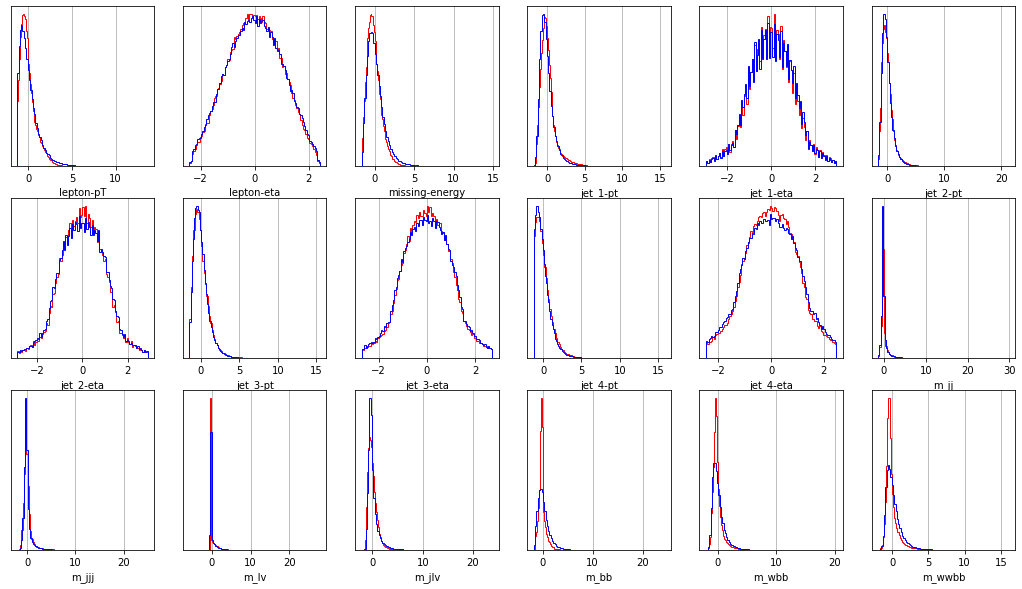

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7165014	best: 0.7165014 (0)	total: 292ms	remaining: 14.3s
1:	test: 0.7238727	best: 0.7238727 (1)	total: 469ms	remaining: 11.3s
2:	test: 0.7254304	best: 0.7254304 (2)	total: 654ms	remaining: 10.2s
3:	test: 0.7265658	best: 0.7265658 (3)	total: 905ms	remaining: 10.4s
4:	test: 0.7266129	best: 0.7266129 (4)	total: 1.03s	remaining: 9.25s
5:	test: 0.7271830	best: 0.7271830 (5)	total: 1.19s	remaining: 8.69s
6:	test: 0.7270335	best: 0.7271830 (5)	total: 1.33s	remaining: 8.17s
7:	test: 0.7280006	best: 0.7280006 (7)	total: 1.46s	remaining: 7.67s
8:	test: 0.7281711	best: 0.7281711 (8)	total: 1.59s	remaining: 7.26s
9:	test: 0.7287500	best: 0.7287500 (9)	total: 1.71s	remaining: 6.84s
10:	test: 0.7290635	best: 0.7290635 (10)	total: 1.85s	remaining: 6.57s
11:	test: 0.7289358	best: 0.7290635 (10)	total: 2s	remaining: 6.34s
12:	test: 0.7292818	best: 0.7292818 (12)	total: 2.19s	remaining: 6.24s
13:	test: 0.7291168	best: 0.7292818 (12)	total: 2.33s	remaining: 5.99s
14:	test: 0.7293030	best: 0.7

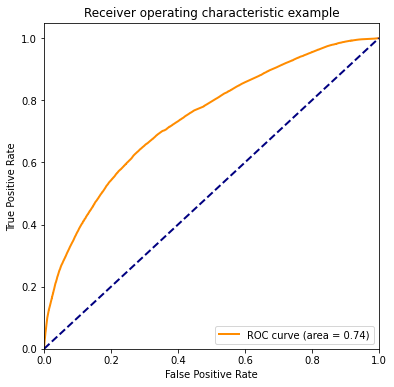

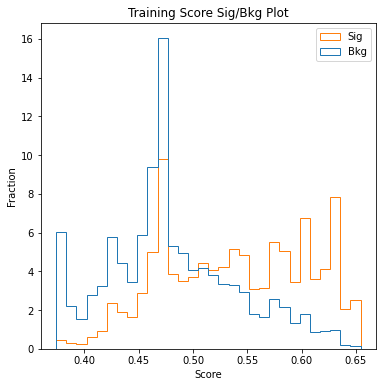

In [7]:
main(50)